## Song Embeddings - Skipgram Recommender

In this notebook, we'll use human-made music playlists to learn song embeddings. We'll treat a playlist as if it's a sentence and the songs it contains as words. We feed that to the word2vec algorithm which then learns embeddings for every song we have. These embeddings can then be used to recommend similar songs. This technique is used by Spotify, AirBnB, Alibaba, and others. It accounts for a vast portion of their user activity, user media consumption, and/or sales (in the case of Alibaba).

The [dataset we'll use](https://www.cs.cornell.edu/~shuochen/lme/data_page.html) was collected by Shuo Chen from Cornell University. The dataset contains playlists from hundreds of radio stations from around the US.

## Importing packages and dataset

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from urllib import request
import warnings
warnings.filterwarnings('ignore')

The playlist dataset is a text file where every line represents a playlist. That playlist is basically a series of song IDs.

In [2]:
# Obtener el archivo del conjunto de datos de listas de reproducción
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

# Analizar el archivo del conjunto de datos de listas de reproducción. Saltar las dos primeras líneas, ya que
# solo contienen metadatos
lines = data.read().decode("utf-8").split('\n')[2:]

# Eliminar listas de reproducción con solo una canción
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]

The `playlists` variable now contains a python list. Each item in this list is a playlist containing song ids. We can look at the first two playlists here:

In [3]:
# Imprimir la primera lista de reproducción
print('Playlist #1:\n ', playlists[0], '\n')

# Imprimir la segunda lista de reproducción
print('Playlist #2:\n ', playlists[1])


Playlist #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

Playlist #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117',

## Training the Word2Vec Model
Our dataset is now in the shape the the Word2Vec model expects as input. We pass the dataset to the model.

In [4]:
# Crear un modelo Word2Vec a partir de las listas de reproducción
model = Word2Vec(playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4)

The model is now trained. Every song has an embedding. We only have song IDs, though, no titles or other info. Let's grab the song information file.

## Song Title and Artist File
Let's load and parse the file containing song titles and artists

In [5]:
# Obtener el archivo con los datos de las canciones
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')

# Leer y decodificar el archivo, separando las líneas
songs_file = songs_file.read().decode("utf-8").split('\n')

# Crear una lista de canciones separando los campos por tabulaciones
songs = [s.rstrip().split('\t') for s in songs_file]

In [6]:
# Crear un DataFrame a partir de la lista de canciones con columnas específicas
songs_df = pd.DataFrame(data=songs, columns=['id', 'title', 'artist'])

# Establecer la columna 'id' como el índice del DataFrame
songs_df = songs_df.set_index('id')

In [7]:
# Mostrar las primeras filas del DataFrame de canciones
songs_df.head()

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


In [8]:
songs_df.shape

(75263, 2)

Se seleccionan como llaves, las 10 canciones mas populares dentro de las playslists. Se identifican de la siguiente manera:

In [9]:
from collections import Counter

# Aplanar la lista de playlists en una sola lista de canciones
all_songs = [song for playlist in playlists for song in playlist]

# Contar la frecuencia de cada canción
song_counts = Counter(all_songs)

# Obtener las canciones más comunes
most_common_songs = song_counts.most_common(10)  # Puedes cambiar 10 por la cantidad de canciones que desees

# Imprimir las canciones más comunes y sus frecuencias
for song_id, frequency in most_common_songs:
    print(f"Canción ID: {song_id}, Frecuencia: {frequency}")

Canción ID: 20065, Frecuencia: 5593
Canción ID: 5, Frecuencia: 5041
Canción ID: 46, Frecuencia: 4497
Canción ID: 7233, Frecuencia: 3828
Canción ID: 20627, Frecuencia: 3767
Canción ID: 19477, Frecuencia: 3686
Canción ID: 20068, Frecuencia: 3583
Canción ID: 60, Frecuencia: 3488
Canción ID: 82, Frecuencia: 3436
Canción ID: 9659, Frecuencia: 3361


In [10]:
row_indices = [5, 46, 60, 82, 7233, 9659, 19477, 20065, 20068, 20627]
songs_df.iloc[row_indices]

,title,artist
id,,
5,Down On Me (w\/ 50 Cent),Jeremih
46,What's My Name (w\/ Drake),Rihanna
60,Just The Way You Are,Bruno Mars
82,Only Girl (In The World),Rihanna
7233,Grenade,Bruno Mars
9659,Firework,Katy Perry
19477,6 Foot 7 Foot (w\/ Cory Gunz),Lil Wayne
20065,Moment 4 Life (w\/ Drake),Nicki Minaj
20068,All Of The Lights,Kanye West


Se miran las recomendaciones iniciales para las cinco primeras canciones

Moment 4 Life (w\/ Drake)

In [11]:
song_id = 20065

# Ask the model for songs similar to song #2172
model.wv.most_similar(positive=str(song_id))

[('20068', 0.9903501868247986),
 ('5', 0.9897254705429077),
 ('20627', 0.9888359904289246),
 ('1', 0.982270359992981),
 ('77', 0.9818991422653198),
 ('19477', 0.9760158061981201),
 ('27076', 0.9718366265296936),
 ('26735', 0.963797926902771),
 ('210', 0.9637647271156311),
 ('292', 0.9623075127601624)]

Down On Me (w/ 50 Cent)

In [12]:
song_id = 5

# Ask the model for songs similar to song #2172
model.wv.most_similar(positive=str(song_id))

[('20068', 0.9958176016807556),
 ('20065', 0.9897254705429077),
 ('20627', 0.9849537014961243),
 ('19477', 0.9784832000732422),
 ('27076', 0.9779016375541687),
 ('26735', 0.9716373085975647),
 ('292', 0.9697691798210144),
 ('1', 0.9683199524879456),
 ('210', 0.9673671722412109),
 ('27132', 0.9642190933227539)]

What's My Name (w\/ Drake)

In [13]:
song_id = 46

# Ask the model for songs similar to song #2172
model.wv.most_similar(positive=str(song_id))

[('6', 0.984065592288971),
 ('77', 0.9474937915802002),
 ('53', 0.9370765686035156),
 ('20070', 0.9328258037567139),
 ('1', 0.9219623804092407),
 ('20065', 0.9177792072296143),
 ('275', 0.9134490489959717),
 ('20627', 0.9052852988243103),
 ('5', 0.9050435423851013),
 ('20068', 0.9032335877418518)]

Grenade

In [14]:
song_id = 7233

# Ask the model for songs similar to song #2172
model.wv.most_similar(positive=str(song_id))

[('27074', 0.9640551805496216),
 ('475', 0.9512630701065063),
 ('8721', 0.9512027502059937),
 ('26350', 0.9457255601882935),
 ('1422', 0.9399935007095337),
 ('20064', 0.9306867718696594),
 ('1406', 0.9259744882583618),
 ('83', 0.9232689142227173),
 ('22596', 0.9215224981307983),
 ('22600', 0.921180009841919)]

Look At Me Now (w\/ Lil Wayne & Busta Rhymes)

In [15]:
song_id = 20627

# Ask the model for songs similar to song #2172
model.wv.most_similar(positive=str(song_id))

[('20068', 0.9924174547195435),
 ('20065', 0.9888359308242798),
 ('5', 0.9849536418914795),
 ('27076', 0.9801581501960754),
 ('19477', 0.9740416407585144),
 ('26735', 0.9695495367050171),
 ('27132', 0.9686691761016846),
 ('77', 0.9673523902893066),
 ('292', 0.9654609560966492),
 ('53', 0.9625101089477539)]

### Exercise:

Build visualization for the embeddings of the song recommender.

In [22]:
# Definir los IDs de canciones de interés
keys = ['5', '46', '60', '82', '7233', '9659', '19477', '20065', '20068', '20627']

embedding_clusters = []  # Lista para almacenar los embeddings de las palabras más similares
word_clusters = []       # Lista para almacenar las palabras más similares

for word in keys:
    embeddings = []  # Lista temporal para almacenar los embeddings de las palabras similares a 'word'
    words = []       # Lista temporal para almacenar las palabras similares a 'word'
    similar_words = model.wv.most_similar(word, topn=30)
    for similar_word, _ in similar_words:
        words.append(similar_word)           # Agregar la palabra similar a la lista temporal
        embeddings.append(model.wv[similar_word])  # Agregar el embedding de la palabra similar

    embedding_clusters.append(embeddings)  # Guardar los embeddings de las palabras similares
    word_clusters.append(words)            # Guardar las palabras similares

In [30]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)

# Obtener las dimensiones del array: n = número de palabras clave (o clusters), m = número de palabras similares, k = dimensiones del embedding
n, m, k = embedding_clusters.shape

# Inicializar el modelo t-SNE con las configuraciones dadas
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=1500, random_state=920311)

# Aplicar t-SNE a los embeddings:
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

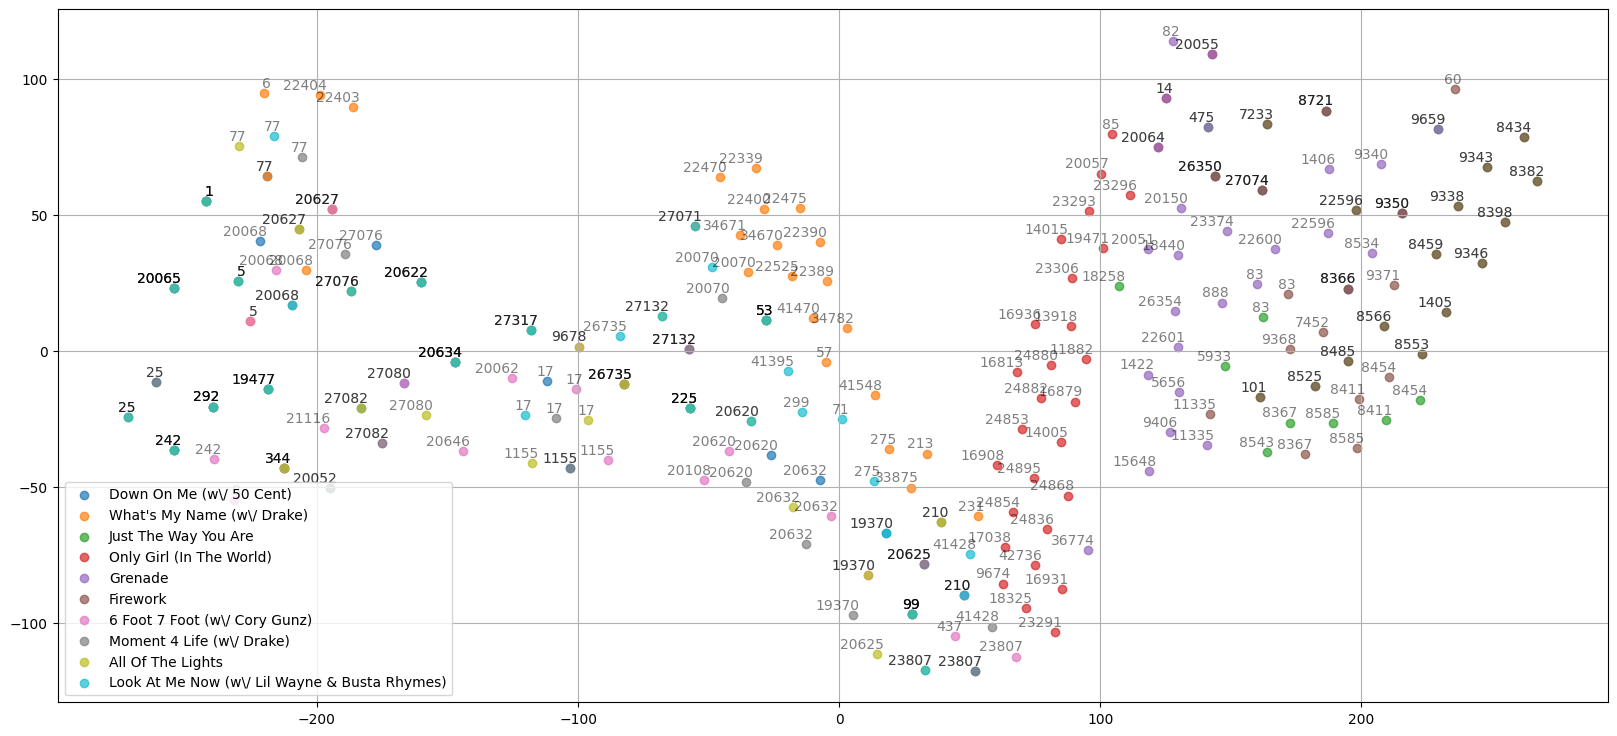

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Función para crear gráficos 2D de embeddings usando Matplotlib
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(20, 9))  # Configurar tamaño del gráfico

    # Iterar sobre cada conjunto de etiquetas, embeddings y palabras
    for label, embeddings, words in zip(labels, embedding_clusters, word_clusters):
        x = embeddings[:, 0]  # Coordenada X
        y = embeddings[:, 1]  # Coordenada Y
        plt.scatter(x, y, alpha=a, label=label)  # Graficar los puntos
        # Anotar cada punto con la palabra correspondiente
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)

    plt.legend(loc=3)  # Mostrar leyenda en la esquina inferior derecha
    plt.grid(True)  # Activar la cuadrícula
    plt.show()  # Mostrar el gráfico

# Definir etiquetas para los clusters
song_titles = ["Down On Me (w\/ 50 Cent)", "What's My Name (w\/ Drake)", "Just The Way You Are", "Only Girl (In The World)", "Grenade", "Firework", "6 Foot 7 Foot (w\/ Cory Gunz)", "Moment 4 Life (w\/ Drake)", "All Of The Lights", "Look At Me Now (w\/ Lil Wayne & Busta Rhymes)" ]

# Llamar a la función para generar el gráfico con las nuevas etiquetas
tsne_plot_similar_words(song_titles, embeddings_en_2d, word_clusters)